# Estimates of Value-at-Risk and Expected Shortfall for shares of a Bucharest Stock Exchange-traded company, 2015-2019

**Author:** Nicholas VJ Alexander


In [2]:
%reset -f
!pip -q install nbconvert
!pip -q install ipython
!pip -q install yfinance
!pip -q install matplotlib
!pip -q install cryptography
import requests, getpass, base64, os, pickle, random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from IPython.display import Markdown as md
from datetime import datetime
from scipy.stats import norm, t, binom, binomtest, skew, kurtosis, chi2, levy_stable
from scipy.optimize import minimize
from scipy.special import gamma
from scipy.integrate import quad
from cryptography.fernet import Fernet
from cryptography.hazmat.primitives.kdf.pbkdf2 import PBKDF2HMAC
from cryptography.hazmat.backends import default_backend
from cryptography.hazmat.primitives import hashes

Matplotlib is building the font cache; this may take a moment.


In [3]:
currtime = datetime.now().strftime('%Y-%m-%d %H:%M UTC')
md(f"**Most recently updated:** {currtime}")

**Most recently updated:** 2024-01-22 08:28 UTC


**Contact:** https://www.linkedin.com/in/nvalexander

---

**Abstract:**

This working paper tests several methods of estimation for Value-at-Risk (VaR), comparing their performance with the actual findings over the subsequent 12 months.

---

**Disclaimer:**

This file is work in progress. As long as this disclaimer is included, its results are not to be assumed as correct.

---


The European Union is at the forefront of global banking reforms aimed at mitigating risks in the private banking system. Additionally, the core objective of the European Banking Authority is a transparent banking environment. To these goals, Directive 2013/36/EU of the European Parliament and of the Council, and its implementation, Commission Implementing Regulation (eu) 2019/912, require adherence to Basel III rules across the EU member states. The latter's Annex 4 requires Credit Institutions disclose, every year, "Own funds requirements for market risk" using "standardized methods".

The strictness of these regulations is merely a façade. The current Basel framework approach, in the section "MAR33. Internal models approach: capital requirements calculation", states that "supervisors may permit banks to use models based on either historical simulation, Monte Carlo simulation, or other appropriate analytical methods". Hence, in this working paper, I will test several methods for estimating Value-at-Risk (VaR) in a hypothetical portfolio comprising a single type of equity, namely a company traded on the Bucharest Stock Exchange.

In broad terms, Value at Risk (VaR) serves as a benchmark to quantify potential losses within extreme scenarios. For instance, when employing a 95% confidence level, VaR represents the minimum percentage loss that could occur on the most unfavorable 5% of trading days for the analyzed portfolio. Recognizing that VaR still describes an optimistic scenario, regulatory guidelines also mandate the computation of Expected Shortfall (ES), which represents the average percentage losses anticipated on those lowest 5% of days. Per RiskMetrics Technical Document, J.P. Morgan/Reuters, 4th ed, 1996: 
 
\begin{equation}
VaR = max(X_i| X_i \in W)
\end{equation}

Per Coherent Measures of Risk, Artzner & Delbaen & Eber & Heath, 1999, https://doi.org/10.1111/1467-9965.00068:

\begin{equation}
ES = E[X_i| X_i \in W]
\end{equation}

In both cases, W is the subset of Xi generally termed Worst Case Scenario, and most commonly defined as a function of a 

\begin{equation}
W = \{X_i |  X_i \leq Q_{1-\alpha}(X) \}
\end{equation}

Note that, throughout this paper, we will describe VaR and ES as raw estimates, on the same scale as the returns that they are derived from, rather than changing sign, applying to the price of a share and / or applying to a hypothetical portfolio of a given value or content.

## Data collection

Closing values for the interval 2015-2019 were obtained using an HTTP scraper written by the author. As it not clear whether scraping bvb.ro data is in agreement with its rules, I protected a trivial section of the scraper with a password in the code posted on Github. Closing values were convered to percent change.

In [4]:
cache_file = 'data/cache.pkl'
ticker = 'EL'
startdate = '2015-01-01'
enddate = '2020-01-01'
n_simulations_kuiper = 10000
n_simulations_asf = 10000
n_bootstrap_z2 = 10000
n_simulations_mc = 10000
alpha_kuiper = 0.05
confidence_level_VaR_ES = 0.95

if os.path.exists(cache_file):
    with open(cache_file, 'rb') as f:
        cache = pickle.load(f)
        sharedata = cache.get('sharedata', None)
else:
    sharedata = None

def key_from_password(password: str, salt: bytes):
    kdf = PBKDF2HMAC(
        algorithm=hashes.SHA256(),
        length=32,
        salt=base64.urlsafe_b64decode(salt),
        iterations=100000,
        backend=default_backend()
    )
    key = base64.urlsafe_b64encode(kdf.derive(password.encode()))
    return key

def decrypt_message(encrypted_message, password, salt):
    key = key_from_password(password, salt)
    fernet = Fernet(key)
    try:
        decrypted_message = fernet.decrypt(encrypted_message.encode()).decode()
        return decrypted_message
    except:
        return None

def fetch_bvb_data(ticker, startdate, enddate):
    start_timestamp = int(datetime.strptime(startdate, '%Y-%m-%d').timestamp())
    end_timestamp = int(datetime.strptime(enddate, '%Y-%m-%d').timestamp())
    url_template = decrypt_message(
        'gAAAAABlrAl5yVctyT7ySvJckZw-Ji9CofturK9duVDA8GS'
        'G8IutAlPtLe7CBAkmuiC9aW9ICjWL6CYAhRfF5zyUiwi3FNf'
        'dFJNXzdZvX4fHgp-PWELaeHEO21GNAbd1PS-vnrvzQFeWLk'
        'gWai9TD6cchKF4Q7Dsvnqr2PF01KJXgKvpmuUln51PRMDgn3'
        'd35PBoPX4kNAZHT0Y0RiJc4RWSzMOQ4DOXRqV0ycSrI0NOjxiGX6b7BWc=',
        password,
        'vGmK5XnOd3trf7uCOa0baQ=='
    )
    url = url_template.format(ticker=ticker, start_timestamp=start_timestamp, end_timestamp=end_timestamp)
    referrer_template = decrypt_message(
        'gAAAAABlq-CfDvJGetCCbdadT9aEdRwD9AjQNL9CcYh8aINR_'
        'uiBOOrD_58SDsTN9pO0IE4twO2ohut3SMEHpFRSfskGWv6N048'
        'H3y1yKQWWhyb-kpFPuLhFA6UkkTvLcKduTBwxXFG4m8LeP-RPk'
        'Ycxi9TrHjX3uTkrFcBKIyA54XtgWcMvLr22XDeMaWLCg2bN85W5UadJ', 
        password,
        'RYGlNyoOQupNEt4l0f8IdQ=='
        )
    referrer = referrer_template.format(ticker=ticker)
    if not referrer:
        print("Incorrect password, cannot decrypt the URL.")
        return pd.DataFrame()
    headers = {'Referer': referrer}
    response = requests.get(url, headers=headers)
    del url
    del referrer
    del headers
    if response.status_code != 200:
        return pd.DataFrame()  # Returns an empty DataFrame in case of HTTP errors
    data = response.json()
    if data.get('s') != 'ok':
        return pd.DataFrame()  # Return an empty DataFrame if status is not 'ok'
    return pd.DataFrame({
        'Date': [datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d') for ts in data['t']],
        'Open': data['o'],
        'High': data['h'],
        'Low': data['l'],
        'Close': data['c'],
        'Volume': data['v']
    })

if sharedata is None:
    password = getpass.getpass("Enter your BVB fetcher password: ")
    sharedata = fetch_bvb_data(ticker, startdate, enddate)
    del password
    cache = {}
    if os.path.exists(cache_file):
        with open(cache_file, 'rb') as f:
            cache = pickle.load(f)
    cache['sharedata'] = sharedata
    with open(cache_file, 'wb') as f:
        pickle.dump(cache, f)

sharedata['DateTime'] = pd.to_datetime(sharedata['Date'])
sharedata = sharedata.sort_values(by='DateTime')
sharedata['DailyReturn'] = sharedata['Close'].pct_change()

Plotting closing prices shows several epochs with dominant trend.

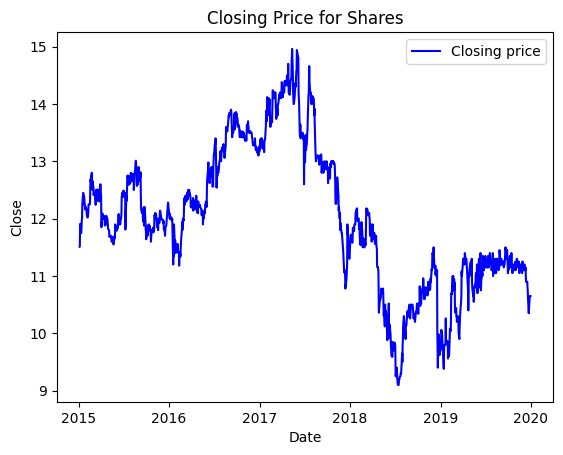

In [5]:
plt.plot(sharedata['DateTime'], sharedata['Close'], label='Closing price', color='blue')
plt.xlabel('Date')
plt.ylabel('Close')
plt.title('Closing Price for Shares')
plt.legend()
plt.show()

Plotting the daily returns does not indicate any extreme values in the data.

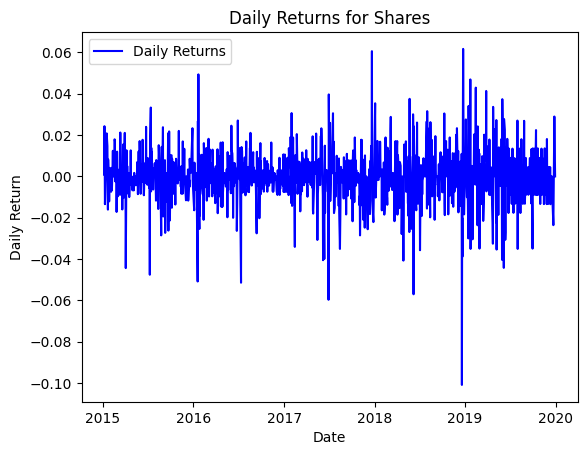

In [6]:
plt.plot(sharedata['DateTime'], sharedata['DailyReturn'], label='Daily Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.title('Daily Returns for Shares')
plt.legend()
plt.show()

The data was split into a calculation (training) data set comprising four years (2015-2018) and a verification (test) set comprising data from 2019.

In [7]:
returns = sharedata[['DailyReturn', 'DateTime']].dropna()
train_data_with_dates = returns[(returns['DateTime'] >= '2015-01-01') & (returns['DateTime'] < '2019-01-01')]
train_data = train_data_with_dates['DailyReturn']
test_data_with_dates = returns[returns['DateTime'] >= '2019-01-01']
test_data = test_data_with_dates['DailyReturn'].dropna()
md(f"In the training dataset, daily returns spanned the interval {min(train_data) * 100:.2f}%"
   f" to {max(train_data) * 100:.2f}%, with a median of "
   f"{np.median(train_data) * 100:.2f}% and a mean of "
   f"{np.mean(train_data) * 100:.2f}%."
   )


In the training dataset, daily returns spanned the interval -10.09% to 6.17%, with a median of 0.00% and a mean of -0.01%.

Before testing the various methods of estimation for VaR, it is important to establish that the training data set and the test data set come from similar distributions. One way to measure the similarity it is the Kuiper test.

In [8]:
def ecdf(data):
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n
    return x, y

x_train, y_train = ecdf(train_data)
x_test, y_test = ecdf(test_data)
combined_x = np.unique(np.concatenate((x_train, x_test)))
y_train_interp = np.interp(combined_x, x_train, y_train, left=0, right=1)
y_test_interp = np.interp(combined_x, x_test, y_test, left=0, right=1)
D_plus = np.max(y_test_interp - y_train_interp)
D_minus = np.max(y_train_interp - y_test_interp)
kuiper_statistic = D_plus + D_minus

# There is no table of critical values for Kuiper test in standard Python
# A value will be calculated with simulations using the current data.
combined_data = np.concatenate((train_data, test_data))
kuiper_simulation_dataset = []
for _ in range(n_simulations_kuiper):
    sample1 = np.random.choice(combined_data, size=len(train_data), replace=True)
    sample2 = np.random.choice(combined_data, size=len(test_data), replace=True)
    x_sample1, y_sample1 = ecdf(sample1)
    x_sample2, y_sample2 = ecdf(sample2)
    y_sample1_interp = np.interp(combined_x, x_sample1, y_sample1, left=0, right=1)
    y_sample2_interp = np.interp(combined_x, x_sample2, y_sample2, left=0, right=1)
    D_plus = np.max(y_sample2_interp - y_sample1_interp)
    D_minus = np.max(y_sample1_interp - y_sample2_interp)
    kuiper_stat_sample = D_plus + D_minus
    kuiper_simulation_dataset.append(kuiper_stat_sample)
critical_value = np.percentile(kuiper_simulation_dataset, 100 * (1 - alpha_kuiper))

In [9]:
md(f"For the current data sets, the Kuiper statistic is {kuiper_statistic:.2f}"
   f", whereas the critical value, calculated using simulations on the merged dataset, is approximately "
   f"{critical_value:.2f}."
   )

For the current data sets, the Kuiper statistic is 0.25, whereas the critical value, calculated using simulations on the merged dataset, is approximately 0.12.

A Kuiper statistic larger than the critical value indicates that the data seen in the test data set does not follow the same distribution as the training data set, a fact which is likely to impair my VaR and ES estimates, in particular invalidating the verification stage, regardless of the estimation method I would use.

Nevertheless, since the best estimates of VaR on Jan 1st, 2019 are the data points preceding this date, I will use them as such.

Finally, the returns date set may be measured in terms of fitting a normal distribution, by calculating its skewness and kurtosis.

In [10]:
train_skewness = skew(train_data)
train_kurtosis = kurtosis(train_data, fisher = True)  # Fisher's definition is that which ends with subtraction of 3
md(f"For the training data set, the skewness is {train_skewness:.2f},"
   f" and the Fisher-defined excess kurtosis is {train_kurtosis:.2f}."
   )

For the training data set, the skewness is -0.76, and the Fisher-defined excess kurtosis is 8.21.

The training data set's negative skewness suggests that instances of lower-than-average outcomes were more frequent, arguing against the use of a symmetric distribution for data modeling. Additionally, the data displays significant excess kurtosis (also called leptokurtosis), which means that it has more extreme values in its tails than a typical normal distribution would have, again pleading against a normal distribution model.

## Estimations based on the Historical Simulation method

The Historical Simulation method employs the lack of any assumptions regarding historical data. Hence, the worst 5% days from the historical data are identified. Losses incurred in the best of these days provides the upper threshold, VaR, whereas their average provides the ES.

In [11]:
VaR_HS = np.percentile(train_data, (1 - confidence_level_VaR_ES) * 100)
ES_HS = train_data[train_data <= VaR_HS].mean()

md(f"For the Historical Simulation method, using a"
   f" {confidence_level_VaR_ES * 100}% confidence threshold,"
   f" and daily intervals, **VaR is {VaR_HS * 100:.2f}%**"
   f", whereas **ES is {ES_HS * 100:.2f}%**."
   )

For the Historical Simulation method, using a 95.0% confidence threshold, and daily intervals, **VaR is -1.85%**, whereas **ES is -2.98%**.

Here is a graphical representation of the Historical Simulation finding on the time course, as well as on the empirical distribution histogram.

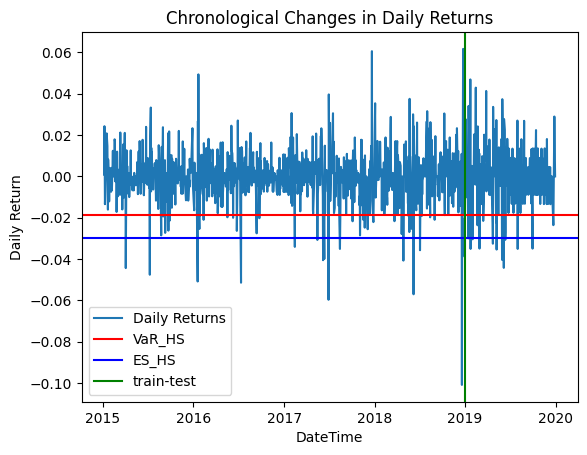

In [12]:
plt.plot(returns['DateTime'],returns['DailyReturn'], label='Daily Returns')
plt.axhline(y=VaR_HS, color='r', linestyle='-', label='VaR_HS')
plt.axhline(y=ES_HS, color='b', linestyle='-', label='ES_HS')
plt.axvline(x=pd.to_datetime('2019-01-01'), color='g', linestyle='-', label='train-test')
plt.xlabel('DateTime')
plt.ylabel('Daily Return')
plt.title('Chronological Changes in Daily Returns')
plt.legend()
plt.show()

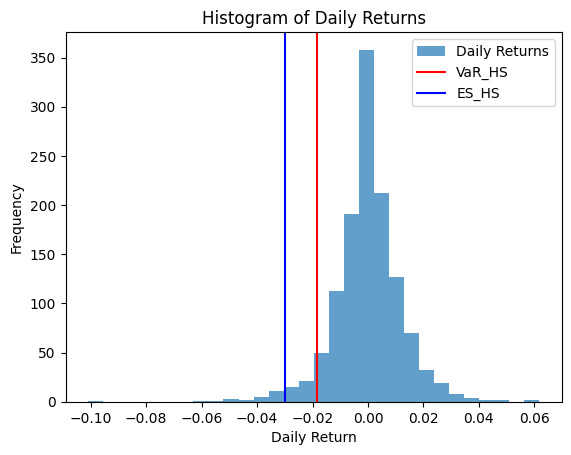

In [13]:
plt.hist(returns['DailyReturn'], bins=30, alpha=0.7, label='Daily Returns')
plt.axvline(x=VaR_HS, color='r', linestyle='-', label='VaR_HS')
plt.axvline(x=ES_HS, color='b', linestyle='-', label='ES_HS')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.title('Histogram of Daily Returns')
plt.legend()
plt.show()

### Backtesting the Historical Simulation model

#### Backtesting VaR estimates

The performance of this model may be measured by comparing its predictions with the 2019 data.

In [14]:
VaR_per_testdata = np.percentile(test_data, (1 - confidence_level_VaR_ES) * 100)
ES_per_testdata = test_data[test_data <= VaR_per_testdata].mean()
expected_breaches = len(test_data) * (1 - confidence_level_VaR_ES)

observed_breaches_HS = test_data[test_data < VaR_HS].count()

md(f"The Historical Simulation method estimated the best return during the worst"
   f" {((1-confidence_level_VaR_ES) * 100):.0f}% trading days (the VaR) at {VaR_HS * 100:.2f}%,"
   f" while in the test dataset, this was in fact {VaR_per_testdata * 100:.2f}%."
   "\n\n"
   f"The test dataset consists of {len(test_data)} data points, which"
   f" means that we would anticipate approximately {expected_breaches:.2f} days"
   f" during which losses would surpass our VaR estimate."
   f" However, in the test dataset, the observed count of days with losses "
   f" exceeding this VaR estimate was {observed_breaches_HS}."
   )

The Historical Simulation method estimated the best return during the worst 5% trading days (the VaR) at -1.85%, while in the test dataset, this was in fact -2.36%.

The test dataset consists of 249 data points, which means that we would anticipate approximately 12.45 days during which losses would surpass our VaR estimate. However, in the test dataset, the observed count of days with losses  exceeding this VaR estimate was 18.

Thus, the Historical Simulation method underestimated the losses incurred in the worst trading days, as well as the number of days with losses beyond VaR.

In order to assess the statistical significance of the differences between prediction and test data, we may compare the observed frequency of days worse than predicted VaR and the expectation for this frequency, which was set at 5%. There are two statistical tests that may be employed. Both have the same null hypothesis, that the number of days worse than the VaR threshold is consistent with a random distribution of these days under a binomial distribution, and therefore both are variants of the Kupiec backtest statistics (Techniques for Verifying the Accuracy of Risk Measurement Models, Kupiec, 1995, https://doi.org/10.3905/jod.1995.407942).

In [15]:
pvalue_binom_HS = binomtest(
  observed_breaches_HS, 
  len(test_data), 
  1 - confidence_level_VaR_ES
  ).pvalue
md(f"In the frequentist approach, the test of a null hypothesis that the data in the test "
   f" dataset belong to the same binomial distribution that would have"
   f" {((1-confidence_level_VaR_ES) * 100):.0f}% days under our VaR estimate, "
   f" returns a p value of {pvalue_binom_HS:.3f}.")

In the frequentist approach, the test of a null hypothesis that the data in the test  dataset belong to the same binomial distribution that would have 5% days under our VaR estimate,  returns a p value of 0.109.

The actual Kupiec backtest statistic, as described in the original paper, is calculated as the log-likelihood ratio:

\begin{equation}
\text{TS} = -2 \ln {\frac{p^x (1-p)^x}{(\frac{n-x}{x})^{n-x} (\frac{x}{n})^{x}}}
\end{equation}

where

- n is the total number of trials (here the number of empiric observations)
- p is the expected relative freqency of an event
- x is the observed absolute frequency of that event.

The null hypothesis in this model is, again, that the empiric frequencies are consistent with a hypothetical Binomial (n, p) distribution, that is, with a random occurence of breaches at the same rate as predicted from the estimated VaR. In order to obtain a p-value, the null hypothesis is restated as "TS is drawn from a chi-square(1) distribution".

In [16]:
def ts(n, p, x):
    LR_numerator = (1 - p)**(n - x) * p**x
    LR_denominator = (1 - x/n)**(n - x) * (x/n)**x
    LR = LR_numerator / LR_denominator
    ts = -2 * np.log(LR)
    return ts


In [17]:
ts_HS = ts(
    len(test_data), 
    (1-confidence_level_VaR_ES),
    observed_breaches_HS
    )
md(f"In the log-likelihood approach, the test for the same null hypothesis returns a"
   f" p value of {chi2.sf(ts_HS, 1):.2f}."
   )

In the log-likelihood approach, the test for the same null hypothesis returns a p value of 0.13.

In both cases, the failure to reject the null hypothesis implies that we lack evidence to suggest a significant difference between the distribution of observed days exceeding the predicted VaR and the expected number of days with losses exceeding the predicted VaR.

A consequence of this statement is that the VaR estimates based on the Historical Simulation model are acceptable to the extent that their estimates are not inferior to a diffferent model.

#### Backtesting ES estimates

In [18]:
md(f"The Historical Simulation method estimated the average return during the worst"
   f" {((1-confidence_level_VaR_ES) * 100):.0f}% trading days (ES) at {ES_HS * 100:.2f}%,"
   f" whereas the test data set shows, in its worst {((1-confidence_level_VaR_ES) * 100):.0f}% "
   f" trading days, an average return of {ES_per_testdata * 100:.2f}%."
)

The Historical Simulation method estimated the average return during the worst 5% trading days (ES) at -2.98%, whereas the test data set shows, in its worst 5%  trading days, an average return of -3.34%.

The Basel standards aimed to replace VaR with ES. However, statistical significance of differences between estimated ES from a training data set and actual ES from verifcation data sets was not testable until recently. In 2016, Acerbi and Szekely proposed three statistical tests and compared them on empirical data. In this paper, I will apply the second method from Backtesting expected shortfall. Introducing three model-independent, non-parametric back-test methodologies for expected shortfall, Acerbi and Szekely, 2014, which was assessed as the most reliable of their three suggestions.

In order to make notation simpler, the two authors defined the exception operator, which is 1 for returns worse than VaR and 0 otherwise:

\begin{equation}
I_t = 
  \begin{cases} 
   1 & \text{if } X_t \leq \text{VaR}_{\text{estimate}} \\
   0 & \text{otherwise}
  \end{cases}
\end{equation}

With this notation, the ES definition may be rewritten:

\begin{equation}
ES_{\alpha} = \frac{1}{\sum_{t=1}^{T}I_t} \sum_{t=1}^{T}{X_t I_t}
\end{equation}

Therefore, in a test data set, the statistic

\begin{equation}
Z_2(\tilde{X}) = -1 + \frac{1}{ES_{\alpha} \times \sum_{t=1}^{T}I_t} \sum_{t=1}^{T} {X_t I_t}
\end{equation}

must deviate very little from 0, if we are to believe the test data set and the training data set have the same ES. The alternative hypothesis is that the ES is significantly different between the training data set and the test data set.

Because the specific distribution of Z2 is not a commonly used one and the Acerbi and Szekely paper do not state a calculation method, I implemented a bootstrap method which will allow me convert Z2 values to p values, according to their recommendations.

This paper deviates from the Acerbi and Szekely formalism in two ways. First, the sign for ES and VaR has been inverted compared to Acerbi and Szekely, in order to keep with the convention used in this paper, that is, to indicate returns rather than losses. Also, ΣIₜ used here replaces what Acerbi and Szekely termed T·α, the former being the actual integer used in the estimation of ES.



In [19]:
def pvalue_z2(testdata, calculatedvar, calculatedes):
    observed_I = (testdata <= calculatedvar).astype(int)
    observed_z2 = -1 + np.sum(testdata * observed_I) / (sum(observed_I) * calculatedes)
    # testing random scenarios for bootstrapping
    bootstrap_z2 = np.empty(n_bootstrap_z2)
    np.random.seed(0)
    random.seed(0)  # It is unclear whether the system seed affects np.random.choice
    for i in range(n_bootstrap_z2):
        resampled_data = np.random.choice(testdata, size=len(testdata), replace=True)
        #VaR_per_resampled = np.percentile(testdata, (1 - confidence_level_VaR_ES) * 100)
        #ES_per_resampled = testdata[testdata <= VaR_per_testdata].mean()
        #resampled_I = (resampled_data <= VaR_per_resampled).astype(int)
        #bootstrap_z2[i] = -1 + np.sum(resampled_data * resampled_I) / (sum(resampled_I) * ES_per_resampled)
        resampled_I = (resampled_data <= calculatedvar).astype(int)
        if sum(resampled_I) > 0:
            bootstrap_z2[i] = -1 + np.sum(resampled_data * resampled_I) / (sum(resampled_I) * calculatedes)
    return observed_z2, np.mean(bootstrap_z2 < observed_z2)

In [20]:
z2_acerbiszekely_HS, pvalue_acerbiszekely_HS = pvalue_z2(test_data, VaR_HS, ES_HS)
md(f"In the Historical Simulation method, the ES estimate corresponds to"
   f" a Z2 statistic of {z2_acerbiszekely_HS:.3f}. The p-value for this Z2 is"
   f" {pvalue_acerbiszekely_HS:.3f}."
   )

In the Historical Simulation method, the ES estimate corresponds to a Z2 statistic of 0.013. The p-value for this Z2 is 0.502.

Thus, there is no evidence that the ES estimae from the training data set would not fit the test data set, when using the Historical Simulation model.

## Estimations based on the Normal Distribution hypothesis

The Normal Distribution method assumes that the historical data, when assumed to be derived from a normal distribution, provide a mean and a standard deviation that may be extrapolated to future data points. In this case, the worst 5% days are identified based on the Z score. Subsequently, VaR and ES are calculated from those means and standard deviations, again using the normal distribution assumption.

In [21]:
mean_Normal, stddev_Normal = norm.fit(train_data)
md(f"The training data set fit a Normal"
   f" Distribution with a mean of "
   f" {(mean_Normal * 100):.2f}% and a standard distribution of"
   f" {(stddev_Normal * 100):.2f}%,"
   )


The training data set fit a Normal Distribution with a mean of  -0.01% and a standard distribution of 1.21%,

The normal distribution estimated this way is modestly similar to the observed distribution in the training data set, as evidenced by the following plot:

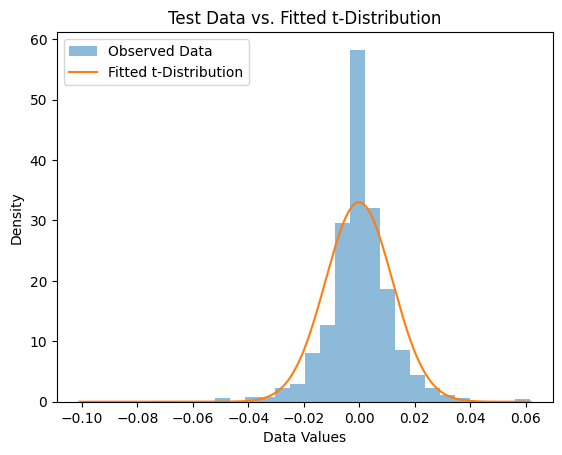

In [22]:
x_values = np.linspace(min(train_data), max(train_data), 1000)
pdf = norm.pdf(x_values, mean_Normal, stddev_Normal)
plt.hist(train_data, bins=30, density=True, alpha=0.5, label='Observed Data')
plt.plot(x_values, pdf, label='Fitted t-Distribution')
plt.xlabel('Data Values')
plt.ylabel('Density')
plt.title('Test Data vs. Fitted t-Distribution')
plt.legend()
plt.show()

The values for mean and standard deviation are subsequently extrapolated the the predicted period of time. While the Var estimate is estimated by a specific percentile of that normal distribution, 

\begin{equation}
\text{VaR}_{\text{Normal}} = \Phi^{-1}(1 - \alpha; \mu, \sigma)
\end{equation}

ES is estimated with;

\begin{equation}
\text{ES}_{\text{Normal}} = \mu - \sigma \times \frac{\phi _{\mu, \sigma} \left(\text{VaR}_{\text{Normal}}\right)}{1 - \alpha}
\end{equation}

where
- Upper case Φ is the proportion of empiric observations falling below a given threshold, that is, the cumulative distribution function (cdf).
- Upper case Φ−1 is the value under which the observations fall, given a specific percentage of empiric observations falling below that threshold, that is, the inverse of the CDF (sometimes called PPF).
- Lower case ϕ is the probability distribution function, calculating the density of the distribution at a specific point (pdf).

In [23]:
VaR_Normal = mean_Normal + stddev_Normal * norm.ppf(1 - confidence_level_VaR_ES)
ES_Normal = mean_Normal - stddev_Normal * norm.pdf(norm.ppf(1 - confidence_level_VaR_ES)) / (1 - confidence_level_VaR_ES)
md(f"For the Normal Distribution method, using a"
   f" {confidence_level_VaR_ES * 100}% confidence threshold,"
   f" and daily intervals, **VaR is {VaR_Normal * 100:.2f}%**"
   f", whereas **ES is {ES_Normal * 100:.2f}%**."
   )

For the Normal Distribution method, using a 95.0% confidence threshold, and daily intervals, **VaR is -2.00%**, whereas **ES is -2.50%**.

Here is a graphical representation of the Normal Distribution finding on the time course, as well as on the empirical distribution histogram.

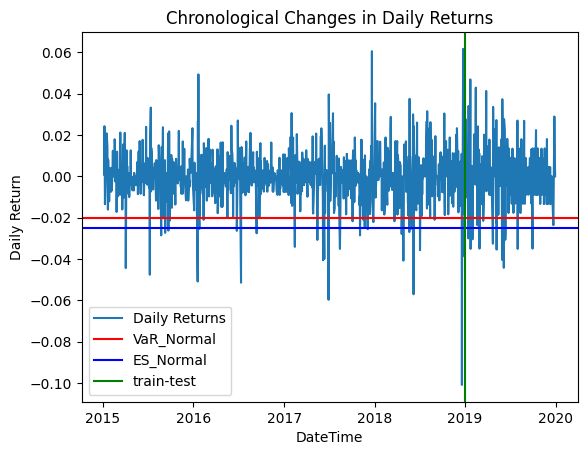

In [24]:
plt.plot(returns['DateTime'],returns['DailyReturn'], label='Daily Returns')
plt.axhline(y=VaR_Normal, color='r', linestyle='-', label='VaR_Normal')
plt.axhline(y=ES_Normal, color='b', linestyle='-', label='ES_Normal')
plt.axvline(x=pd.to_datetime('2019-01-01'), color='g', linestyle='-', label='train-test')
plt.xlabel('DateTime')
plt.ylabel('Daily Return')
plt.title('Chronological Changes in Daily Returns')
plt.legend()
plt.show()

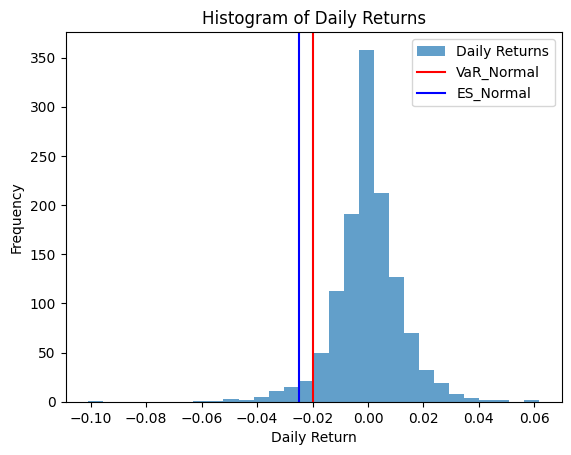

In [25]:
plt.hist(returns['DailyReturn'], bins=30, alpha=0.7, label='Daily Returns')
plt.axvline(x=VaR_Normal, color='r', linestyle='-', label='VaR_Normal')
plt.axvline(x=ES_Normal, color='b', linestyle='-', label='ES_Normal')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.title('Histogram of Daily Returns')
plt.legend()
plt.show()

### Backtesting the Normal Distribution model

#### Backtesting VaR estimates

The performance of VaR estimated through the Normal Distribution model may be measured by comparing its predictions with the 2019 data.

In [26]:
observed_breaches_Normal = test_data[test_data < VaR_Normal].count()

md(f"The Normal Distribution method estimated the best return during the worst"
   f" {((1-confidence_level_VaR_ES) * 100):.0f}% trading days (the VaR) at {VaR_Normal * 100:.2f}%,"
   f" while in the test dataset, this was in fact {VaR_per_testdata * 100:.2f}%."
   "\n\n"
   f"The test dataset consists of {len(test_data)} data points, which"
   f" means that we would anticipate approximately {expected_breaches:.2f} days"
   f" during which losses would surpass our VaR estimate."
   f" However, in the test dataset, the observed count of days with losses "
   f" exceeding this VaR estimate was {observed_breaches_Normal}."
   )

The Normal Distribution method estimated the best return during the worst 5% trading days (the VaR) at -2.00%, while in the test dataset, this was in fact -2.36%.

The test dataset consists of 249 data points, which means that we would anticipate approximately 12.45 days during which losses would surpass our VaR estimate. However, in the test dataset, the observed count of days with losses  exceeding this VaR estimate was 17.

The Normal Distribution method underestimated the losses incurred in the worst trading days, as well as the number of days with losses beyond VaR.

In order to assess the statistical significance of the differences between training and test data, we may compare the observed frequency of days worse than predicted VaR and the expectation for this frequency, using the Kupiec backtesting procedure, in the log-likelihood approach.

In [27]:
ts_Normal = ts(
    len(test_data), 
    (1-confidence_level_VaR_ES),
    observed_breaches_Normal
    )
md(f"The statistical test which has a null hypothesis the assumption that the "
   f" number of trading days in the test set for which losses are worse "
   f" than the estimated VaR is compatible with a random Binomial(n, p) "
   f" distribution returns a p value of {chi2.sf(ts_Normal, 1):.2f}."
   )

The statistical test which has a null hypothesis the assumption that the  number of trading days in the test set for which losses are worse  than the estimated VaR is compatible with a random Binomial(n, p)  distribution returns a p value of 0.21.

It is apparent that the Normal Distribution model, albeit poorly performing, is not systematicaly erroneous in its VaR estimation.

#### Backtesting ES estimates

In [28]:
md(f"The Normal Distribution method estimated the average return during the worst"
   f" {((1-confidence_level_VaR_ES) * 100):.0f}% trading days (ES) at {ES_Normal * 100:.2f}%,"
   f" whereas the test data set shows, in its worst {((1-confidence_level_VaR_ES) * 100):.0f}% "
   f" trading days, an average return of {ES_per_testdata * 100:.2f}%."
)

The Normal Distribution method estimated the average return during the worst 5% trading days (ES) at -2.50%, whereas the test data set shows, in its worst 5%  trading days, an average return of -3.34%.

To test whether ES estimated in the calculation data differs systematically from the test data set, we can apply the backtesting method described by Acerbi and Szekely.

In [29]:
z2_acerbiszekely_Normal, pvalue_acerbiszekely_Normal = pvalue_z2(test_data, VaR_Normal, ES_Normal)
md(f"In the Normal Distribution method, that ES estimate corresponds to"
   f" a Z2 statistic of {z2_acerbiszekely_Normal:.3f}. The p-value for this Z2 is"
   f" {pvalue_acerbiszekely_Normal:.3f}."
   )

In the Normal Distribution method, that ES estimate corresponds to a Z2 statistic of 0.233. The p-value for this Z2 is 0.501.

The ES estimate through the Normal Distribution model has a large Z2 statistic, suggesting intense discrepancies between it and the data in the test data set.

## Estimations based on the t-Student Distribution hypothesis

The t-Student Distribution method assumes that the historical data fit a t-Student distribution that may be extrapolated to future data points. The t-Student distribution is similar to the normal distribution in many aspects, such as symmetry, but it usually better suited for modelling returns, due to its heavier tails. Its PDF is given by the equation:

\begin{equation}
f(x | \nu, \mu, \sigma) = \frac{\Gamma\left(\frac{\nu + 1}{2}\right)}{\sqrt{\nu\pi}\, \Gamma\left(\frac{\nu}{2}\right)} \left(1 + \frac{1}{\nu}\left(\frac{x - \mu}{\sigma}\right)^2\right)^{-\frac{\nu + 1}{2}}
\end{equation}

where:

- x is the variable.
- ν is the degrees of freedom.
- μ is the mean of the distribution, also known as the location parameter
- σ is the standard deviation of the distribution, also known as the scale parameter
- Γ is the gamma function.

The gamma function is the extrapolation of the factorial to non-natural numbers, and is calculated with:

\begin{equation}
\Gamma(z) = \int_{0}^{\infty} t^{z-1} e^{-t} dt
\end{equation}

In this case, the first step towards the estimation of VaR is the estimation of ν, μ and σ.

In [30]:
nu_t, mu_t, sigma_t = t.fit(train_data)
md(f"The training data fit a t-Student "
   f" Distribution with a mean of "
   f" {(mu_t * 100):.2f}%, a standard distribution of"
   f" {(sigma_t * 100):.2f}%,  and a number of "
   f" {(nu_t * 100):.2f} degrees of freedom."
   )

The training data fit a t-Student  Distribution with a mean of  0.02%, a standard distribution of 0.72%,  and a number of  273.32 degrees of freedom.

The estimates for ν, μ and σ yield a hypothetical t-Student Distribution rather similar to the observed data:

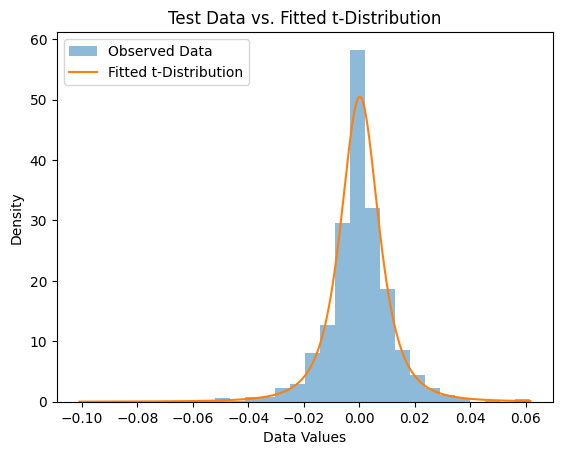

In [31]:
x_values = np.linspace(min(train_data), max(train_data), 1000)
pdf = t.pdf(x_values, nu_t, mu_t, sigma_t)
plt.hist(train_data, bins=30, density=True, alpha=0.5, label='Observed Data')
plt.plot(x_values, pdf, label='Fitted t-Distribution')
plt.xlabel('Data Values')
plt.ylabel('Density')
plt.title('Test Data vs. Fitted t-Distribution')
plt.legend()
plt.show()


In the t-Distribution approach, the worst 5% days are identified based on the distribution of probabilities stemming from its PDF f(x | ν, μ, σ) described above. Specifically, VaR is calculated with F-1(q), the inverse of the CDF:

\begin{equation}
VaR_{t-Student} = \mu + \sigma \times \sqrt {\frac {\nu}{\nu - 2}} \times F^{-1}(1 - \alpha, \nu)
\end{equation}

The correction factor is the mathematical consequence of the fat tails in the t-Student distribution (Source: Continuous Univariate Distributions, Volume 2, Johnson & Kotz & Balakrishnan, 1995, isbn: 9780471584940, p. 366).

ES may be calculated when the pdf f(x) is also used (see Quantitative Risk Management: Concepts, Techniques and Tools, McNeil & Rudiger & Embrechts, Revides Edition, 2015, isbn:9781400866281, p 71):

\begin{equation}
\text{ES} = \mu_t - \sigma \times \sqrt {\frac {\nu}{\nu - 2}} \times \frac{f (F^{-1}(1 - \alpha, \nu), \nu)}{1 - \alpha} \times \frac{\nu + (f( 1 - \alpha, \nu))^2}{\nu - 1}
\end{equation}

In [32]:
VaR_t = mu_t + sigma_t * np.sqrt(nu_t / (nu_t - 2)) * t.ppf(1 - confidence_level_VaR_ES, nu_t)
#VaR_t_alternative = mu_t + sigma_t * t.ppf(1 - confidence_level_VaR_ES)
#VaR_t_normalized = mu_t + sigma_t * np.sqrt(nu_t / (nu_t - 2)) * norm.ppf(1 - confidence_level_VaR_ES)
ES_t = (mu_t - 
    (sigma_t * np.sqrt(nu_t / (nu_t - 2))) * 
    (t.pdf(t.ppf(1 - confidence_level_VaR_ES, df=nu_t), df=nu_t) / (1 - confidence_level_VaR_ES)) * 
    ((nu_t + t.ppf(1 - confidence_level_VaR_ES, df=nu_t)**2) / (nu_t - 1))
)

md(f"For the t-Student Distribution method, using a"
   f" {confidence_level_VaR_ES * 100}% confidence threshold,"
   f" and daily intervals, **VaR is {VaR_t * 100:.2f}%**"
   f", whereas **ES is {ES_t * 100:.2f}%**."
   )

For the t-Student Distribution method, using a 95.0% confidence threshold, and daily intervals, **VaR is -3.40%**, whereas **ES is -5.84%**.

Here is a graphical representation of the  t-Student Distribution findings on the time course, as well as on the empirical distribution histogram.

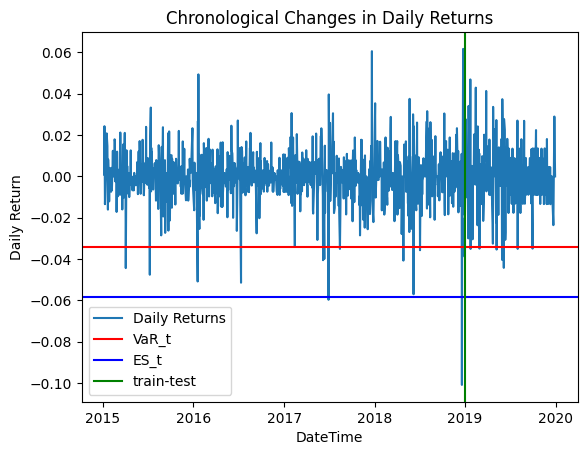

In [33]:
plt.plot(returns['DateTime'],returns['DailyReturn'], label='Daily Returns')
plt.axhline(y=VaR_t, color='r', linestyle='-', label='VaR_t')
plt.axhline(y=ES_t, color='b', linestyle='-', label='ES_t')
plt.axvline(x=pd.to_datetime('2019-01-01'), color='g', linestyle='-', label='train-test')
plt.xlabel('DateTime')
plt.ylabel('Daily Return')
plt.title('Chronological Changes in Daily Returns')
plt.legend()
plt.show()

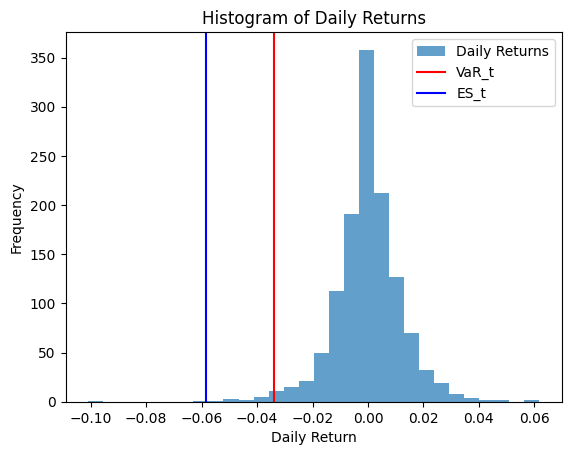

In [34]:
plt.hist(returns['DailyReturn'], bins=30, alpha=0.7, label='Daily Returns')
plt.axvline(x=VaR_t, color='r', linestyle='-', label='VaR_t')
plt.axvline(x=ES_t, color='b', linestyle='-', label='ES_t')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.title('Histogram of Daily Returns')
plt.legend()
plt.show()

### Backtesting the t-Student model

#### Backtesting the VaR estimate

The performance of VaR estimated through the Normal Distribution model may be measured by comparing its predictions with the 2019 data.

In [35]:
observed_breaches_t = test_data[test_data < VaR_t].count()

md(f"The t-Student Distribution method estimated the best return during the worst"
   f" {((1-confidence_level_VaR_ES) * 100):.0f}% trading days (the VaR) at {VaR_t * 100:.2f}%,"
   f" while in the test dataset, this was in fact {VaR_per_testdata * 100:.2f}%."
   "\n\n"
   f"The test dataset consists of {len(test_data)} data points, which"
   f" means that we would anticipate approximately {expected_breaches:.2f} days"
   f" during which losses would surpass our VaR estimate."
   f" However, in the test dataset, the observed count of days with losses "
   f" exceeding this VaR estimate was {observed_breaches_t}."
   )

The t-Student Distribution method estimated the best return during the worst 5% trading days (the VaR) at -3.40%, while in the test dataset, this was in fact -2.36%.

The test dataset consists of 249 data points, which means that we would anticipate approximately 12.45 days during which losses would surpass our VaR estimate. However, in the test dataset, the observed count of days with losses  exceeding this VaR estimate was 7.

The t-Student Distribution method overestimated the losses incurred in the worst trading days, at least for their ceiling (VaR). This abnormal selection of extremely severe cases led to an extreme underestimation of the number of days with losses beyond VaR.

In order to assess the statistical significance of the differences between training and test data, we may compare the observed frequency of days worse than predicted VaR and the expectation for this frequency, using the Kupiec backtesting procedure, in the log-likelihood approach.

In [36]:
ts_t = ts(
    len(test_data), 
    (1-confidence_level_VaR_ES),
    observed_breaches_t
    )
md(f"The statistical test which has a null hypothesis the assumption that the "
   f" number of trading days in the test set for which losses are worse "
   f" than the estimated VaR is compatible with a random Binomial(n, p) "
   f" distribution returns a p value of {chi2.sf(ts_t, 1):.2f}."
   )

The statistical test which has a null hypothesis the assumption that the  number of trading days in the test set for which losses are worse  than the estimated VaR is compatible with a random Binomial(n, p)  distribution returns a p value of 0.09.

Nevertheless, the Kuipec backtesting procedure using the log-likelihod approach, does not support its alternative hypothesis, which claims that the number of trading days with losses more severe than the estimated VaR is systematically different from what would be predicted by a Binomial(n, p) distribution.

#### Backtesting the ES estimate

In [37]:
md(f"The t-Student Distribution method estimated the average return during the worst"
   f" {((1-confidence_level_VaR_ES) * 100):.0f}% trading days (ES) at {ES_t * 100:.2f}%,"
   f" whereas the test data set shows, in its worst {((1-confidence_level_VaR_ES) * 100):.0f}% "
   f" trading days, an average return of {ES_per_testdata * 100:.2f}%."
)

The t-Student Distribution method estimated the average return during the worst 5% trading days (ES) at -5.84%, whereas the test data set shows, in its worst 5%  trading days, an average return of -3.34%.

To test whether ES estimated in the calculation data differs systematically from the test data set, we can apply the backtesting method described by Acerbi and Szekely.

In [38]:
z2_acerbiszekely_t, pvalue_acerbiszekely_t = pvalue_z2(test_data, VaR_t, ES_t)
md(f"In the t-Student Distribution method, that ES estimate corresponds to"
   f" a Z2 statistic of {z2_acerbiszekely_t:.3f}. The p-value for this Z2 is"
   f" {pvalue_acerbiszekely_t:.3f}."
   )

In the t-Student Distribution method, that ES estimate corresponds to a Z2 statistic of -0.364. The p-value for this Z2 is 0.527.

The ES estimate through the t-Student Distribution model has a large Z2 statistic, suggesting systematic differences between it and the data in the test data set.

## Estimations based on the Alpha-Stable Function model

Alpha-stable functions (ASF) are a generalization of several classes of functions, among which I have already discussed the t-Student and the Normal distribution. There are several advantages to their use, most notably, in our case, being the ability to medel skewed data.

Although the specifics regarding ASF are beyind the scope of this paper, it must be mentioned that they are tyoically dependent on four numeric parameters:
- alpha, also called the exponent, or the stability paramenter controls the tails
- beta, also called the skewness parameter
- gamma, also called the scale, playing a role similar to the scale of the student distribution
- delta, also called the location, playing a role similar to the location of the student distribution.

In [39]:
def neg_log_likelihood(params):
    alpha, beta, gamma, delta = params
    print(params)
    # Ensure parameters are within their valid range
    if not (0 < alpha <= 2) or not (-1 <= beta <= 1):
        return np.inf
    return -np.sum(levy_stable.logpdf(train_data, alpha, beta, loc=delta, scale=gamma))

# Initial guess for the parameters
initial_params = [1, 0, np.std(train_data), np.mean(train_data)]
# Better guesses from a previous run
initial_params = [1.55, -0.0054, 0.006, 0.000188]
# Parameter bounds for alpha, beta, gamma and delta
param_bounds = [(1e-6, 2), (-1, 1), (1e-6, None), (None, None)]

# Minimize the negative log-likelihood
#result = minimize(neg_log_likelihood, initial_params, bounds=param_bounds, method='Nelder-Mead')
# Extract the fitted parameters
#alpha, beta, gamma, delta = result.x
alpha, beta, gamma, delta = 1.5506475844762866, -0.05252000932864612, 0.006003639096258409, 3.982718656882555e-05


In [40]:
md(f"By running a Nelder-Mead optimization algorithm, the data in the training data "
      f" set was fitted to the following values: "
      "\n\n"
      f"- alpha: {alpha:.3f}"
      "\n\n"
      f"- beta: {beta:.3f}"
      "\n\n"
      f"- gamma: {gamma:.3f}"
      "\n\n"
      f"- delta: {delta:.5f}."
      )

By running a Nelder-Mead optimization algorithm, the data in the training data  set was fitted to the following values: 

- alpha: 1.551

- beta: -0.053

- gamma: 0.006

- delta: 0.00004.

The chart built with these parameters indicate that the ASF model has good similarity with the empiric data: 

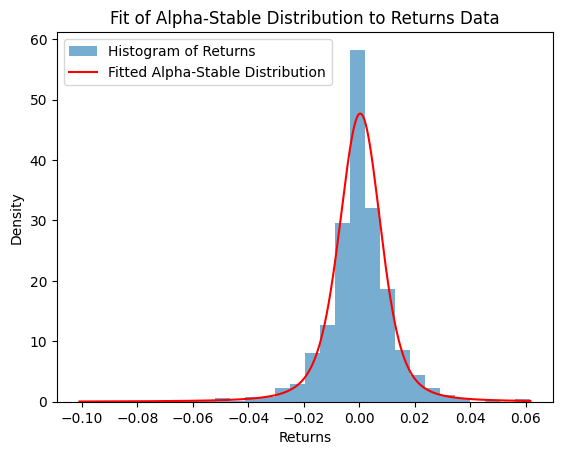

In [41]:
points = np.linspace(min(train_data), max(train_data), 1000)
pdf_values = levy_stable.pdf(points, alpha, beta, loc=delta, scale=gamma)
plt.hist(train_data, bins=30, density=True, alpha=0.6, label='Histogram of Returns')
plt.plot(points, pdf_values, label='Fitted Alpha-Stable Distribution', color='red')
plt.xlabel('Returns')
plt.ylabel('Density')
plt.title('Fit of Alpha-Stable Distribution to Returns Data')
plt.legend()
plt.show()


In [42]:
random.seed(0)
np.random.seed(0)
simulated_returns = levy_stable.rvs(alpha, beta, loc=delta, scale=gamma, size=n_simulations_asf)
VaR_asf = np.quantile(simulated_returns, 1 - confidence_level_VaR_ES)
ES_asf = simulated_returns[simulated_returns <= VaR_asf].mean()

md(f"For the Alpha Stable method, using a"
   f" {confidence_level_VaR_ES * 100}% confidence threshold,"
   f" and daily intervals, **VaR is {VaR_asf * 100:.2f}%**"
   f", whereas **ES is {ES_asf * 100:.2f}%**."
   )

For the Alpha Stable method, using a 95.0% confidence threshold, and daily intervals, **VaR is -1.82%**, whereas **ES is -4.66%**.

Here is a graphical representation of the t-Student Distribution findings on the time course, as well as on the empirical distribution histogram.

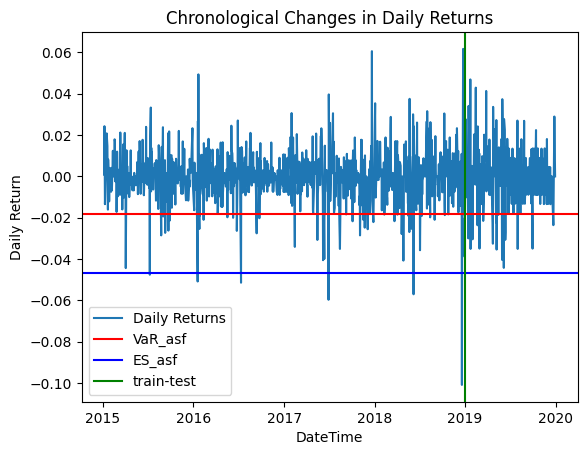

In [43]:
plt.plot(returns['DateTime'],returns['DailyReturn'], label='Daily Returns')
plt.axhline(y=VaR_asf, color='r', linestyle='-', label='VaR_asf')
plt.axhline(y=ES_asf, color='b', linestyle='-', label='ES_asf')
plt.axvline(x=pd.to_datetime('2019-01-01'), color='g', linestyle='-', label='train-test')
plt.xlabel('DateTime')
plt.ylabel('Daily Return')
plt.title('Chronological Changes in Daily Returns')
plt.legend()
plt.show()

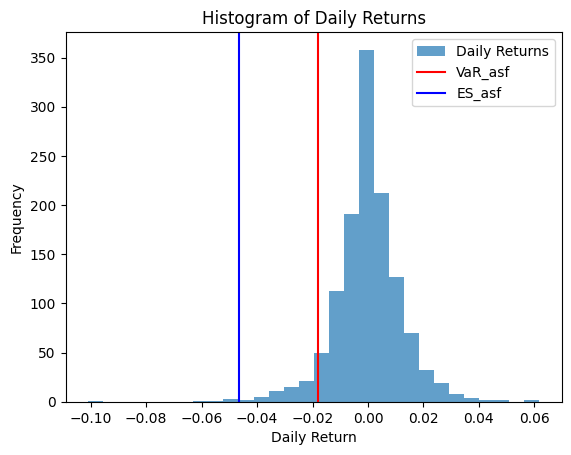

In [44]:
plt.hist(returns['DailyReturn'], bins=30, alpha=0.7, label='Daily Returns')
plt.axvline(x=VaR_asf, color='r', linestyle='-', label='VaR_asf')
plt.axvline(x=ES_asf, color='b', linestyle='-', label='ES_asf')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.title('Histogram of Daily Returns')
plt.legend()
plt.show()

### Backtesting the Alpha Stable Function model

#### Backtesting the VaR estimate

The performance of VaR estimated through the Normal Distribution model may be measured by comparing its predictions with the 2019 data.

In [45]:
observed_breaches_asf = test_data[test_data < VaR_asf].count()

md(f"The ASF Distribution method estimated the best return during the worst"
   f" {((1-confidence_level_VaR_ES) * 100):.0f}% trading days (the VaR) at {VaR_asf * 100:.2f}%,"
   f" while in the test dataset, this was in fact {VaR_per_testdata * 100:.2f}%."
   "\n\n"
   f"The test dataset consists of {len(test_data)} data points, which"
   f" means that we would anticipate approximately {expected_breaches:.2f} days"
   f" during which losses would surpass our VaR estimate."
   f" However, in the test dataset, the observed count of days with losses "
   f" exceeding this VaR estimate was {observed_breaches_asf}."
   )

The ASF Distribution method estimated the best return during the worst 5% trading days (the VaR) at -1.82%, while in the test dataset, this was in fact -2.36%.

The test dataset consists of 249 data points, which means that we would anticipate approximately 12.45 days during which losses would surpass our VaR estimate. However, in the test dataset, the observed count of days with losses  exceeding this VaR estimate was 19.

The ASF method underestimated the losses incurred in the worst trading days, as well as the number of days with losses beyond VaR.

In order to assess the statistical significance of the differences between training and test data, we may compare the observed frequency of days worse than predicted VaR and the expectation for this frequency, using the Kupiec backtesting procedure, in the log-likelihood approach.

In [46]:
ts_asf = ts(
    len(test_data), 
    (1-confidence_level_VaR_ES),
    observed_breaches_asf
    )
md(f"The statistical test which has a null hypothesis the assumption that the "
   f" number of trading days in the test set for which losses are worse "
   f" than the estimated VaR is compatible with a random Binomial(n, p) "
   f" distribution returns a p value of {chi2.sf(ts_asf, 1):.2f}."
   )

The statistical test which has a null hypothesis the assumption that the  number of trading days in the test set for which losses are worse  than the estimated VaR is compatible with a random Binomial(n, p)  distribution returns a p value of 0.08.

A Kuipec backtest using the log-likelihod approach does not support its alternative hypothesis, which claims that the number of trading days with losses more severe than the estimated VaR is systematically different from what would be predicted by a Binomial(n, p) distribution.

#### Backtesting the ES estimate

In [47]:
md(f"The ASF Distribution method estimated the average return during the worst"
   f" {((1-confidence_level_VaR_ES) * 100):.0f}% trading days (ES) at {ES_asf * 100:.2f}%,"
   f" whereas the test data set shows, in its worst {((1-confidence_level_VaR_ES) * 100):.0f}% "
   f" trading days, an average return of {ES_per_testdata * 100:.2f}%."
)

The ASF Distribution method estimated the average return during the worst 5% trading days (ES) at -4.66%, whereas the test data set shows, in its worst 5%  trading days, an average return of -3.34%.

To test whether ES estimated in the calculation data differs systematically from the test data set, we can apply the backtesting method described by Acerbi and Szekely.

In [48]:
z2_acerbiszekely_asf, pvalue_acerbiszekely_asf = pvalue_z2(test_data, VaR_asf, ES_asf)
md(f"In the ASF method, that ES estimate corresponds to"
   f" a Z2 statistic of {z2_acerbiszekely_asf:.3f}. The p-value for this Z2 is"
   f" {pvalue_acerbiszekely_asf:.3f}."
   )

In the ASF method, that ES estimate corresponds to a Z2 statistic of -0.366. The p-value for this Z2 is 0.503.

The ES estimate through the ASF model has a large Z2 statistic, suggesting systematic differences between it and the data in the test data set.

## Estimations based on the Monte Carlo approach

Each of the methods used above (Historical Simulation, Normal Distribution, t-Student Distribution and even ASF) may be improved if the VaR and ES are calculated from series of daily returns that are calculated or otherwise drawn randomly from the historical data series.

In this paper, I created hypothetical annual datasets by randomly extracting, with replacement, daily returns from the training data set. I calculated VaR and ES estimates in each of these hypothetical data sets, and I averaged the hypothetical VaR or ES estimates.


In [49]:
random.seed(0)
np.random.seed(0)
time_horizon = len(test_data)

# Monte Carlo Simulation: Generates 10000 sets of daily returns, each set for one hypothetical year
simulated_returns = np.random.choice(train_data, size=(n_simulations_mc, time_horizon), replace=True)
var_values = []
es_values = []
for i in range(n_simulations_mc):
    sorted_returns = np.sort(simulated_returns[i, :])
    var_index = int((1 - confidence_level_VaR_ES) * time_horizon)
    var = sorted_returns[var_index]
    es = sorted_returns[:var_index].mean() # if var_index > 0 else sorted_returns.mean() # would avoid division by zero
    var_values.append(var)
    es_values.append(es)
VaR_mc = np.mean(var_values)
ES_mc =  np.mean(es_values)

md(f"For the Monte Carlo method with historical data sampling, using a"
   f" {confidence_level_VaR_ES * 100}% confidence threshold,"
   f" and daily intervals, **VaR is {VaR_mc * 100:.2f}%**"
   f", whereas **ES is {ES_mc * 100:.2f}%**."
   )

For the Monte Carlo method with historical data sampling, using a 95.0% confidence threshold, and daily intervals, **VaR is -1.86%**, whereas **ES is -3.02%**.

For completion here are visualizations of all the simulated time courses of the share price starting from a common hypothetical value of 1, as well as histograms for the hypothetical VaR ans ES estimates. Since the VaR can only take one of the historical daily return values, its distribution is not as smooth as that of the ES.

In [50]:
share_price_series = np.zeros((n_simulations_mc, time_horizon))
for i in range(n_simulations_mc):
    # The first value is the initial share price
    share_prices = [1]
    for daily_return in simulated_returns[i, :]:
        share_prices.append(share_prices[-1] * (1 + daily_return))
    share_price_series[i, :] = share_prices[1:] # excludes the day zero share price

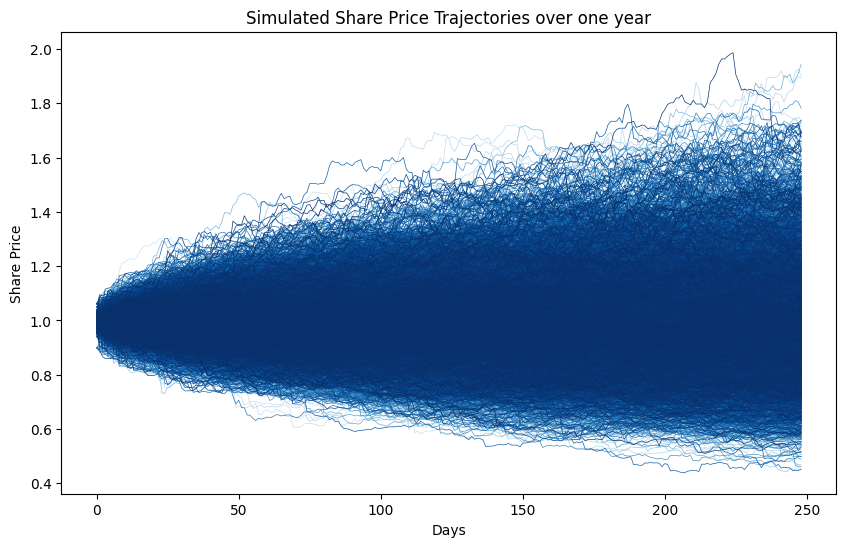

In [51]:
# Plotting the time courses of the share price for each simulation
plt.figure(figsize=(10, 6))
colors = plt.cm.Blues(np.linspace(0.2, 1, n_simulations_mc))
for i in range(n_simulations_mc):
    plt.plot(share_price_series[i, :], color=colors[i], linewidth=0.5)  # Using a thin line
plt.title("Simulated Share Price Trajectories over one year")
plt.xlabel("Days")
plt.ylabel("Share Price")
plt.show()


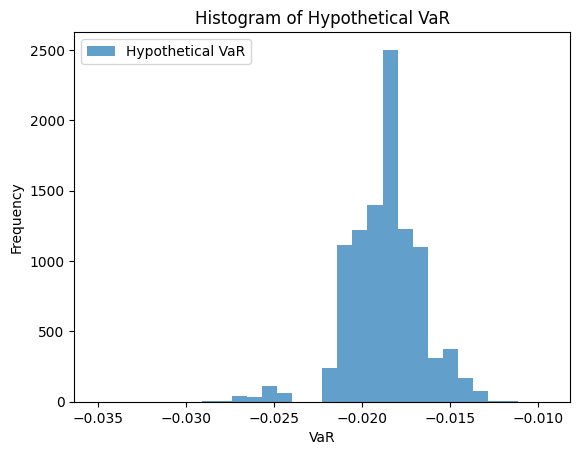

In [52]:
plt.hist(var_values, bins=30, alpha=0.7, label='Hypothetical VaR')
plt.xlabel('VaR')
plt.ylabel('Frequency')
plt.title('Histogram of Hypothetical VaR')
plt.legend()
plt.show()

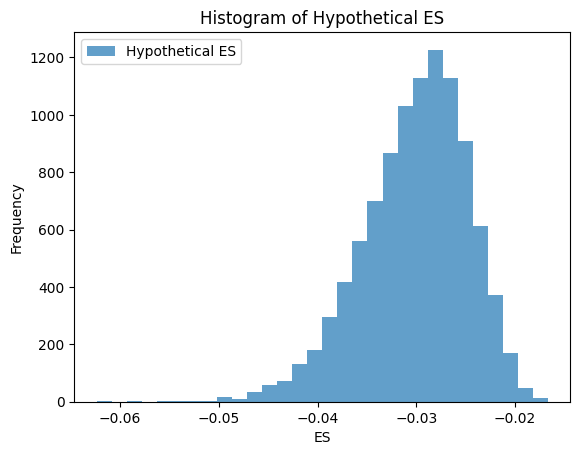

In [53]:
plt.hist(es_values, bins=30, alpha=0.7, label='Hypothetical ES')
plt.xlabel('ES')
plt.ylabel('Frequency')
plt.title('Histogram of Hypothetical ES')
plt.legend()
plt.show()

Here is a graphical representation of the Monte Carlo findings on the time course, as well as on the empirical distribution histogram.

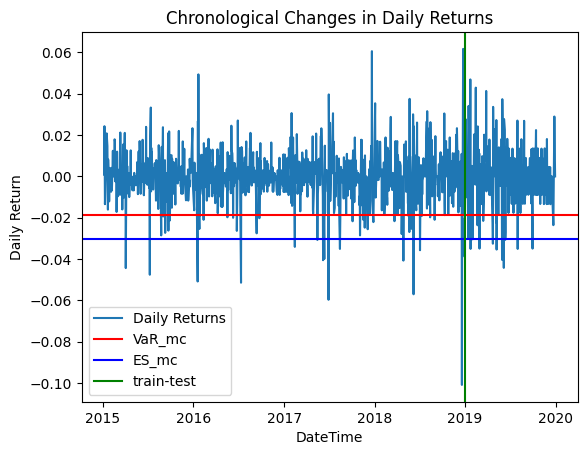

In [54]:
plt.plot(returns['DateTime'],returns['DailyReturn'], label='Daily Returns')
plt.axhline(y=VaR_mc, color='r', linestyle='-', label='VaR_mc')
plt.axhline(y=ES_mc, color='b', linestyle='-', label='ES_mc')
plt.axvline(x=pd.to_datetime('2019-01-01'), color='g', linestyle='-', label='train-test')
plt.xlabel('DateTime')
plt.ylabel('Daily Return')
plt.title('Chronological Changes in Daily Returns')
plt.legend()
plt.show()

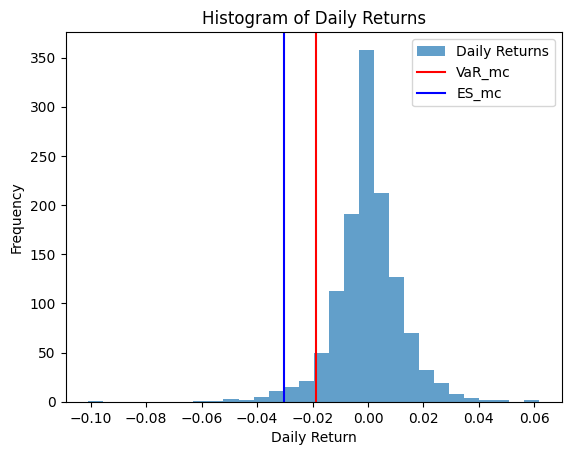

In [55]:
plt.hist(returns['DailyReturn'], bins=30, alpha=0.7, label='Daily Returns')
plt.axvline(x=VaR_mc, color='r', linestyle='-', label='VaR_mc')
plt.axvline(x=ES_mc, color='b', linestyle='-', label='ES_mc')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.title('Histogram of Daily Returns')
plt.legend()
plt.show()

### Backtesting the Monte Carlo model

#### Backtesting the VaR estimate

The performance of VaR estimated through the Normal Distribution model may be measured by comparing its predictions with the 2019 data.

In [56]:
observed_breaches_mc = test_data[test_data < VaR_mc].count()

md(f"The Monte Carlo method estimated the best return during the worst"
   f" {((1-confidence_level_VaR_ES) * 100):.0f}% trading days (the VaR) at {VaR_mc * 100:.2f}%,"
   f" while in the test dataset, this was in fact {VaR_per_testdata * 100:.2f}%."
   "\n\n"
   f"The test dataset consists of {len(test_data)} data points, which"
   f" means that we would anticipate approximately {expected_breaches:.2f} days"
   f" during which losses would surpass our VaR estimate."
   f" However, in the test dataset, the observed count of days with losses "
   f" exceeding this VaR estimate was {observed_breaches_mc}."
   )

The Monte Carlo method estimated the best return during the worst 5% trading days (the VaR) at -1.86%, while in the test dataset, this was in fact -2.36%.

The test dataset consists of 249 data points, which means that we would anticipate approximately 12.45 days during which losses would surpass our VaR estimate. However, in the test dataset, the observed count of days with losses  exceeding this VaR estimate was 18.

The ASF method underestimated the losses incurred in the worst trading days, as well as the number of days with losses beyond VaR.

In order to assess the statistical significance of the differences between training and test data, we may compare the observed frequency of days worse than predicted VaR and the expectation for this frequency, using the Kupiec backtesting procedure, in the log-likelihood approach.

In [57]:
ts_mc = ts(
    len(test_data), 
    (1-confidence_level_VaR_ES),
    observed_breaches_mc
    )
md(f"The statistical test which has a null hypothesis the assumption that the "
   f" number of trading days in the test set for which losses are worse "
   f" than the estimated VaR is compatible with a random Binomial(n, p) "
   f" distribution returns a p value of {chi2.sf(ts_mc, 1):.2f}."
   )

The statistical test which has a null hypothesis the assumption that the  number of trading days in the test set for which losses are worse  than the estimated VaR is compatible with a random Binomial(n, p)  distribution returns a p value of 0.13.

A Kuipec backtest using the log-likelihod approach does not support its alternative hypothesis, which claims that the number of trading days with losses more severe than the estimated VaR is systematically different from what would be predicted by a Binomial(n, p) distribution.

#### Backtesting the ES estimate

In [58]:
z2_acerbiszekely_mc, pvalue_acerbiszekely_mc = pvalue_z2(test_data, VaR_mc, ES_mc)
md(f"In the Monte Carlo method, that ES estimate corresponds to"
   f" a Z2 statistic of {z2_acerbiszekely_mc:.3f}. The p-value for this Z2 is"
   f" {pvalue_acerbiszekely_mc:.3f}."
   )

In the Monte Carlo method, that ES estimate corresponds to a Z2 statistic of 0.001. The p-value for this Z2 is 0.502.

The ES estimate through the Monte Carlo model has a small Z2 statistic. This, together with the Z2 statisic, suggesting there are no difference between the ES estimate from the traiing data set and the data in the test data set.

In using historical data for my Monte Carlo simulation, I obtained results that indistinguishable from that orginating directly from the Historical Simulation model. The use of Monte Carlo methods appears limited to scenarios when a short historical horizon is used.

## Conclusions

In [59]:

tabledata = {
    "Data source": ["TEST data set", "Historical simulation", "Normal Distribution", "t-Student Distribution", "Alpha Stable Distribution", "Monte Carlo"],
    "VaR estimate": [VaR_per_testdata, VaR_HS, VaR_Normal, VaR_t, VaR_asf, VaR_mc],
    "Observed daily breaches": [expected_breaches, observed_breaches_HS, observed_breaches_Normal, observed_breaches_t, observed_breaches_asf, observed_breaches_mc],
    "p value for Kupiec test": ["NA", chi2.sf(ts_HS, 1), chi2.sf(ts_Normal, 1), chi2.sf(ts_t, 1), chi2.sf(ts_asf, 1), chi2.sf(ts_mc, 1)],
    "ES estimate": [ES_per_testdata, ES_HS, ES_Normal, ES_t, ES_asf, ES_mc],
    "Z2 statistic": ["NA", z2_acerbiszekely_HS, z2_acerbiszekely_Normal, z2_acerbiszekely_t, z2_acerbiszekely_asf, z2_acerbiszekely_mc],
    "p value for Z2": ["NA", pvalue_acerbiszekely_HS, pvalue_acerbiszekely_Normal, pvalue_acerbiszekely_t, pvalue_acerbiszekely_asf, pvalue_acerbiszekely_mc]
}

print(pd.DataFrame(tabledata))


                 Data source  VaR estimate  Observed daily breaches  \
0              TEST data set     -0.023616                    12.45   
1      Historical simulation     -0.018487                    18.00   
2        Normal Distribution     -0.019981                    17.00   
3     t-Student Distribution     -0.033994                     7.00   
4  Alpha Stable Distribution     -0.018167                    19.00   
5                Monte Carlo     -0.018604                    18.00   

  p value for Kupiec test  ES estimate Z2 statistic p value for Z2  
0                      NA    -0.033423           NA             NA  
1                 0.12915    -0.029777     0.013396         0.5023  
2                0.208928    -0.025033      0.23266         0.5008  
3                0.085176    -0.058447    -0.364405         0.5275  
4                0.076096    -0.046596    -0.365943         0.5028  
5                 0.12915    -0.030156     0.000675         0.5023  


In this paper, I employed several methods in order to estimate VaR and ES based on 2015-2018 daily returns for Electrica SA. I tested the performances of all these models using data from 2019. With the exception a t-Student Distribution-based model, all the proposed models underestimated VaR and the number of day the losses would be more severe than the VaR threshold. Similarly, with the exception of that t-Student Distribution-based model, all the proposed models underestimated ES.

These results demonstrate that, for good estimations of ES and VaR, the quality of the data and the absence of shocks is more important than the choice of model.